Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from scipy import sparse
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve
import numpy as np
import pickle

Load Dataset

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

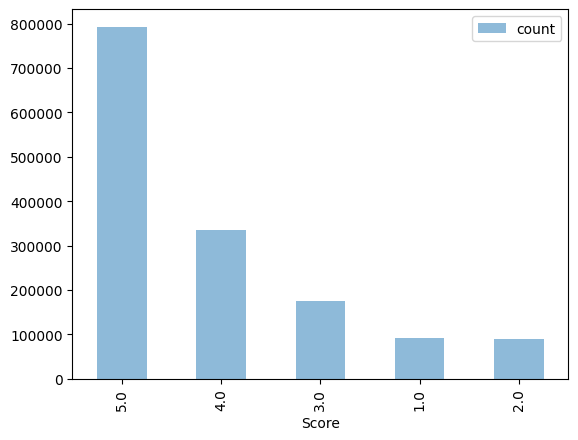


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [14]:
random_state = 42
np.random.seed(random_state)

# Paths to train and test data
training_path = 'train.csv'
test_path = 'test.csv'

# Load datasets
training_data = pd.read_csv(training_path)
training_data_dropped = training_data.dropna()
test_data = pd.read_csv(test_path)

print("train.csv shape is ", training_data.shape)
print("test.csv shape is ", test_data.shape)

print()

print(training_data.head())
print()
print(test_data.head())

print()

print(training_data.describe())

training_data['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

Data Preparation

In [6]:
# Shuffle and create stratified samples of 300,000 rows
training_data_shuffled = training_data.sample(frac=1, random_state=42).reset_index(drop=True)
leftover_data = training_data_shuffled

samples = []

for _ in range(3):
    # Create a stratified sample of 300,000 rows
    sample, leftover_data = train_test_split(leftover_data, train_size=300000, stratify=leftover_data['Score'], random_state=42)
    samples.append(sample)

Using Naive Bayes for feature classification

In [7]:
class NaiveBayesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def _apply_naive_bayes_transformation(self, x, ratio):
        # Apply the Naive Bayes transformation to the input data
        return x.multiply(ratio)

    def _calculate_probability_ratio(self, x, target_class, y):
        # Calculate the probability ratio for the given class
        class_sum = x[y == target_class].sum(axis=0)
        return (class_sum + self.alpha) / ((y == target_class).sum() + self.alpha)

    def fit(self, x, y=None):
        # Fit the model by computing the log count ratio
        positive_class_ratio = self._calculate_probability_ratio(x, 1, y)
        negative_class_ratio = self._calculate_probability_ratio(x, 0, y)
        self._log_count_ratio = sparse.csr_matrix(np.log(positive_class_ratio / negative_class_ratio))
        return self

    def transform(self, x):
        # Transform the input data using the log count ratio
        return self._apply_naive_bayes_transformation(x, self._log_count_ratio)

Pipeline

In [8]:
text_pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=2000)),  # Convert text to TF-IDF features
    ('nb', NaiveBayesTransformer(alpha=1)),  # Apply Naive Bayes transformation
    ('classifier', LogisticRegression(max_iter=500))  # Logistic Regression for classification
])

summary_pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=500)),  # Convert summary to TF-IDF features
    ('nb', NaiveBayesTransformer(alpha=1)),  # Apply Naive Bayes transformation
    ('classifier', LogisticRegression(max_iter=500))  # Logistic Regression for classification
])

 Features

In [9]:
# Create a DataFrame with features extracted from the first sample
feature = pd.DataFrame({
    "Score": samples[0]["Score"],  # Target variable
    "ReviewLength": samples[0]['Text'].apply(len),  # Length of review text
    "TextSubjectivity": samples[0]['Text'].apply(lambda x: TextBlob(x).sentiment.subjectivity if isinstance(x, str) else 0),  # Subjectivity of review text
    "SummarySubjectivity": samples[0]['Summary'].apply(lambda x: TextBlob(x).sentiment.subjectivity if isinstance(x, str) else 0),  # Subjectivity of summary text
    "TextSentimentPolarity": samples[0]['Text'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0),  # Sentiment polarity of review text
    "SummarySentimentPolarity": samples[0]['Summary'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)  # Sentiment polarity of summary text
})

# Add Naive Bayes probabilities as features
class_names = [1.0, 2.0, 3.0, 4.0, 5.0]
for class_name in class_names:
    feature[f'nb_text_prob_{class_name}'] = 0
    feature[f'nb_summary_prob_{class_name}'] = 0

for i, class_name in enumerate(class_names):
    train_target = (samples[1]['Score'] == class_name).astype(int)
    text_pipeline.fit(samples[1]['Text'].values, train_target)
    summary_pipeline.fit(samples[1]['Summary'].values, train_target)

    feature[f'nb_text_prob_{class_name}'] = text_pipeline.predict_proba(samples[0]['Text'].values)[:, 1]
    feature[f'nb_summary_prob_{class_name}'] = summary_pipeline.predict_proba(samples[0]['Summary'].values)[:, 1]

Model Training and Eval

In [10]:
X = feature.drop(columns=["Score"])  # Features
y = feature["Score"]  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

log_reg_model = LogisticRegression(max_iter=500, random_state=42)

# Train the model
log_reg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg_model.predict(X_test)

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Model Accuracy: {accuracy}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Model Accuracy: 0.638
Classification Report:
               precision    recall  f1-score   support

         1.0       0.57      0.54      0.56      3684
         2.0       0.38      0.06      0.10      3622
         3.0       0.42      0.43      0.42      7113
         4.0       0.46      0.32      0.38     13541
         5.0       0.73      0.89      0.80     32040

    accuracy                           0.64     60000
   macro avg       0.51      0.45      0.45     60000
weighted avg       0.60      0.64      0.61     60000



/Users/aarshmehta/aarsh-midterm/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Class Distribution in Training Data

/var/folders/w_/d_xtzqt16fx70tlg2h1m4ptr0000gn/T/ipykernel_46752/2608320525.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Score', data=training_data, palette='viridis')


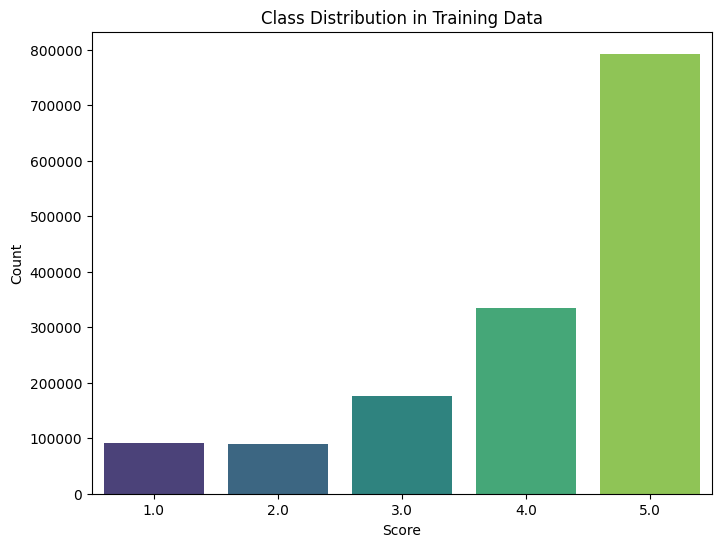

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Score', data=training_data, palette='viridis')
plt.title('Class Distribution in Training Data')  # Title of the plot
plt.xlabel('Score')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.show()

Sentiment Polarity Distribution

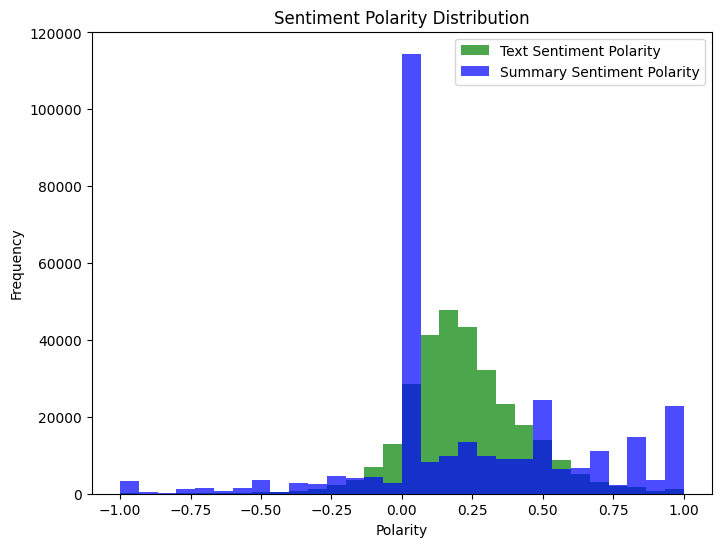

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(feature_df['TextSentimentPolarity'], bins=30, alpha=0.7, color='g', label='Text Sentiment Polarity')  # Histogram for text sentiment polarity
plt.hist(feature_df['SummarySentimentPolarity'], bins=30, alpha=0.7, color='b', label='Summary Sentiment Polarity')  # Histogram for summary sentiment polarity
plt.title('Sentiment Polarity Distribution')  # Title of the plot
plt.xlabel('Polarity')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.legend()  # Add legend
plt.show()

Learning Curve

/Users/aarshmehta/aarsh-midterm/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aarshmehta/aarsh-midterm/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

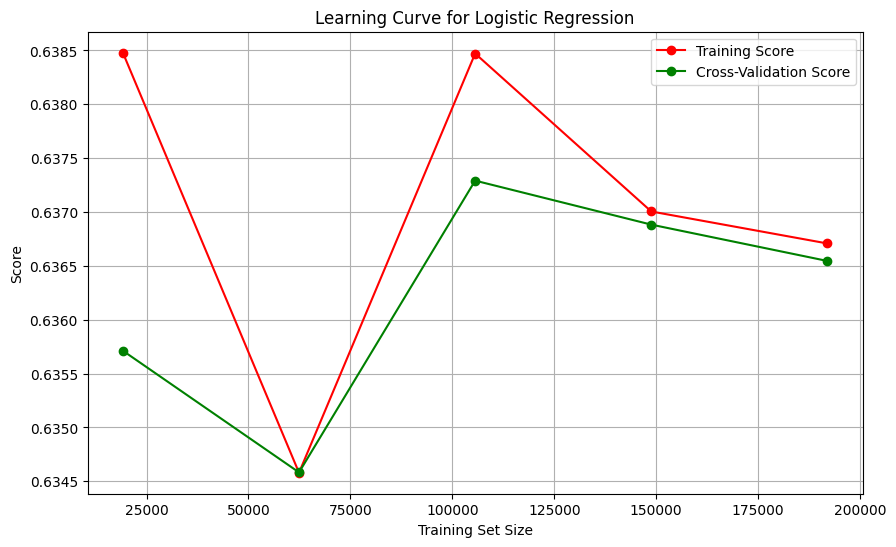

In [13]:
train_sizes, train_scores, test_scores = learning_curve(log_reg_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')  # Plot training scores
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')  # Plot cross-validation scores
plt.title('Learning Curve for Logistic Regression')  # Title of the plot
plt.xlabel('Training Set Size')  # X-axis label
plt.ylabel('Score')  # Y-axis label
plt.legend()  # Add legend
plt.grid()  # Add grid
plt.show()

Precision-Recall Curve

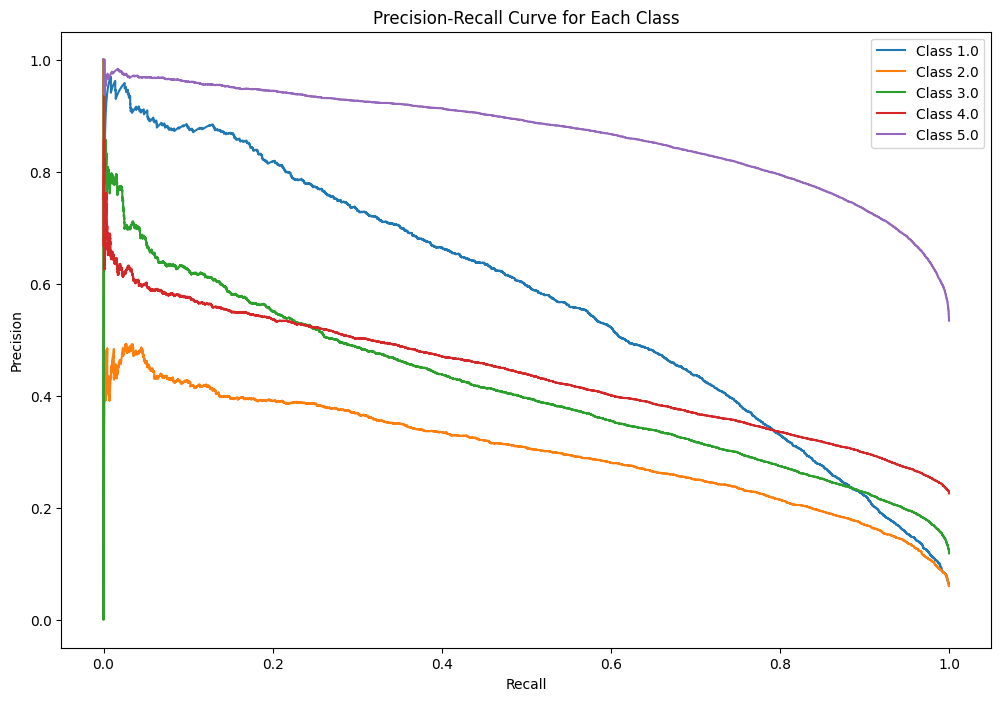

In [15]:
# Precision-Recall Curve for Multiclass
plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_names):
    # Get the scores for the current class
    y_scores = log_reg_model.predict_proba(X_test)[:, i]
    
    # Calculate precision and recall
    precisions, recalls, thresholds = precision_recall_curve(y_test == class_name, y_scores)

    # Plot the precision-recall curve for the current class
    plt.plot(recalls, precisions, label=f'Class {class_name}')

plt.xlabel('Recall')  # X-axis label
plt.ylabel('Precision')  # Y-axis label
plt.title('Precision-Recall Curve for Each Class')  # Title of the plot
plt.legend()  # Add legend
plt.show()


Confusion Matrix

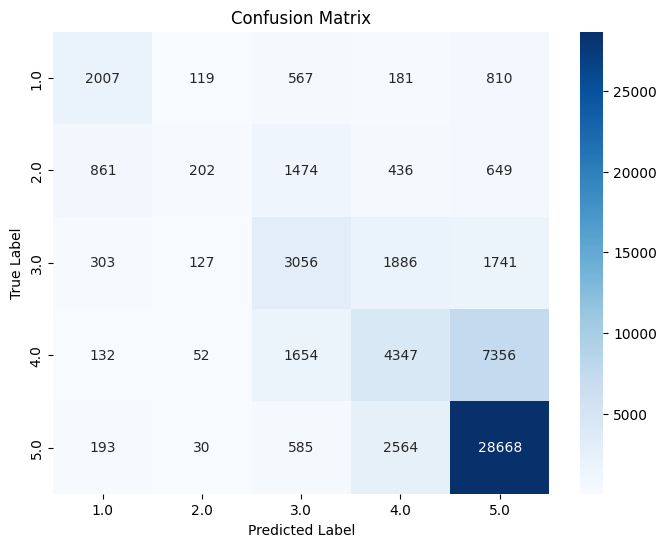

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)  # Heatmap for confusion matrix
plt.xlabel("Predicted Label")  # X-axis label
plt.ylabel("True Label")  # Y-axis label
plt.title("Confusion Matrix")  # Title of the plot
plt.show()

Testing on New Data and Saving Predictions

In [19]:
# Testing on new data and saving predictions
similiarity_thread = training_data[training_data['Id'].isin(test_data['Id'])].copy()
similiarity_thread['ReviewLength'] = similiarity_thread['Text'].apply(lambda x: len(x) if isinstance(x, str) else 0)
similiarity_thread['TextSentimentPolarity'] = similiarity_thread['Text'].apply(lambda text: TextBlob(text).sentiment.polarity if isinstance(text, str) else 0)
similiarity_thread['TextSubjectivity'] = similiarity_thread['Text'].apply(lambda text: TextBlob(text).sentiment.subjectivity if isinstance(text, str) else 0)
similiarity_thread['SummarySentimentPolarity'] = similiarity_thread['Summary'].apply(lambda summary: TextBlob(summary).sentiment.polarity if isinstance(summary, str) else 0)
similiarity_thread['SummarySubjectivity'] = similiarity_thread['Summary'].apply(lambda summary: TextBlob(summary).sentiment.subjectivity if isinstance(summary, str) else 0)
similiarity_thread['Text'] = similiarity_thread['Text'].fillna("")
similiarity_thread['Summary'] = similiarity_thread['Summary'].fillna("")

for class_name in class_names:
    similiarity_thread[f'nb_text_prob_{class_name}'] = 0
    similiarity_thread[f'nb_summary_prob_{class_name}'] = 0

for i, class_name in enumerate(class_names):
    train_target = (samples[1]['Score'] == class_name).astype(int)
    text_pipeline.fit(samples[1]['Text'].values, train_target)
    summary_pipeline.fit(samples[1]['Summary'].values, train_target)

    similiarity_thread[f'nb_text_prob_{class_name}'] = text_pipeline.predict_proba(similiarity_thread['Text'].values)[:, 1]
    similiarity_thread[f'nb_summary_prob_{class_name}'] = summary_pipeline.predict_proba(similiarity_thread['Summary'].values)[:, 1]

columns_to_drop = ["Id", "ProductId", "UserId", "HelpfulnessNumerator", "HelpfulnessDenominator", "Time", "Summary", "Text", "Score"]

similiarity_thread_for_prediction = similiarity_thread.drop(columns=columns_to_drop, errors='ignore')[X_train.columns]

prediction = log_reg_model.predict(similiarity_thread_for_prediction)
similiarity_thread['Score'] = prediction

Save predicted scores to CSV


In [20]:
prediction_df = similiarity_thread[['Id', 'Score']]
prediction_df.to_csv("submission.csv", index=False)